# Basic Usage

### Setup
This tutorial notebook will walk you through the basic usage of the OTTER API. First make sure you followed the installation structions to install otter and the data. First the imports we will need for the notebook

In [1]:
import os
import otter

from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pyplot as plt
import numpy as np

We can initiate the otter database object and then get metadata of all of the data. From there, we can easily get the default redshift for each object and histogram them.

In [ ]:
db = otter.Otter()
meta = db.get_meta(save=False)
redshifts = np.array([t.get_redshift() for t in meta if "distance" in t and len(t["distance"]) > 0])
fig, ax = plt.subplots()
ax.hist(redshifts.astype(float), bins=20)
ax.set_ylabel("N")
ax.set_xlabel("z")

### Querying the OTTER Catalog

Now that we have the catalog read in an initiated, we can query it for the data we want. Say we want to get all of the data associated with the TDE Sw J1644+57, we can use

In [3]:
swj1644_list = db.query(names='Sw J1644+57')
swj1644_list

[Transient(
 	Name: Sw J1644+57,
 	Keys: dict_keys(['_key', '_id', '_rev', 'coordinate', 'filter_alias', 'photometry', 'name', 'reference_alias', 'classification', 'host', 'schema_version', 'distance', 'date_reference'])
 )]

Which you can see is a list of otter `Transient` objects. You can essentially treat this like a python dictionary with some benefits:
* It has additional helpful methods to access and clean the data
* You can use the HDF5 slash-syntax. Ex.) `swj1644['name/alias']` will give you all of the aliases from the `alias` subkey in the `name` key

In [4]:
swj1644 = swj1644_list[0] # just to get rid of the list

swj1644['name/alias']

[{'value': 'Swift J1644+57',
  'reference': ['2017ApJ...838..149A',
   '2011Sci...333..203B',
   '2023PASP..135c4101G']},
 {'value': 'GRB 110328A', 'reference': ['2011Sci...333..203B']},
 {'value': 'Sw J1644+57', 'reference': ['Swift', '2011Natur.476..425Z']},
 {'value': 'Swift J164449.3+573451', 'reference': ['2011Sci...333..203B']},
 {'value': 'SwJ1644+57',
  'reference': ['2011Natur.476..425Z', '2011Natur.476..425Z']}]

So this TDE has multiple aliases associated with it! Let's try to query by a different one

In [5]:
db.query(names='GRB 110328A')[0]

Transient(
	Name: Sw J1644+57,
	Keys: dict_keys(['_key', '_id', '_rev', 'coordinate', 'filter_alias', 'photometry', 'name', 'reference_alias', 'classification', 'host', 'schema_version', 'distance', 'date_reference'])
)

And look at that, it gives us the same answer! We can also query by a list of names which will give us a list of transient objects back:

In [6]:
db.query(names=['Sw J1644+57', '2018hyz', '2018zr'])

[Transient(
 	Name: Sw J1644+57,
 	Keys: dict_keys(['_key', '_id', '_rev', 'coordinate', 'filter_alias', 'photometry', 'name', 'reference_alias', 'classification', 'host', 'schema_version', 'distance', 'date_reference'])
 ),
 Transient(
 	Name: 2018hyz,
 	Keys: dict_keys(['_key', '_id', '_rev', 'classification', 'reference_alias', 'coordinate', 'name', 'date_reference', 'distance', 'filter_alias', 'photometry', 'schema_version'])
 ),
 Transient(
 	Name: 2018zr,
 	Keys: dict_keys(['_key', '_id', '_rev', 'classification', 'reference_alias', 'coordinate', 'name', 'date_reference', 'distance', 'filter_alias', 'photometry', 'host', 'schema_version'])
 )]

We can also search OTTER for anything within a certain redshift range, let's look for everything between $0.1 < z <0.2$:

In [7]:
db.query(minz=0.1, maxz=0.2)

[Transient(
 	Name: SRGE J013204.6+122236,
 	Keys: dict_keys(['_key', '_id', '_rev', 'schema_version', 'name', 'classification', 'distance', 'coordinate', 'date_reference', 'host', 'reference_alias'])
 ),
 Transient(
 	Name: 2021crk,
 	Keys: dict_keys(['_key', '_id', '_rev', 'classification', 'reference_alias', 'coordinate', 'name', 'date_reference', 'distance', 'photometry', 'filter_alias'])
 ),
 Transient(
 	Name: 2017bcc,
 	Keys: dict_keys(['_key', '_id', '_rev', 'classification', 'reference_alias', 'coordinate', 'name', 'date_reference', 'distance', 'host', 'filter_alias', 'photometry', 'schema_version'])
 ),
 Transient(
 	Name: 2018lni,
 	Keys: dict_keys(['_key', '_id', '_rev', 'coordinate', 'name', 'date_reference', 'reference_alias', 'classification', 'photometry', 'filter_alias', 'distance'])
 ),
 Transient(
 	Name: PTF09djl,
 	Keys: dict_keys(['_key', '_id', '_rev', 'name', 'coordinate', 'reference_alias', 'date_reference', 'distance', 'classification', 'schema_version', 'filt

WOW! That's a lot of TDEs. But that's expected since many of them are discovered nearby. What if we look for everything with a redshift over 1?

In [8]:
db.query(minz=1)

[Transient(
 	Name: 2022cmc,
 	Keys: dict_keys(['_key', '_id', '_rev', 'coordinate', 'name', 'date_reference', 'reference_alias', 'classification', 'filter_alias', 'photometry', 'schema_version', 'distance'])
 ),
 Transient(
 	Name: Sw J2058+05,
 	Keys: dict_keys(['_key', '_id', '_rev', 'photometry', 'filter_alias', 'classification', 'date_reference', 'distance', 'reference_alias', 'name', 'coordinate', 'schema_version', 'host'])
 ),
 Transient(
 	Name: CXOU J0332,
 	Keys: dict_keys(['_key', '_id', '_rev', 'name', 'coordinate', 'reference_alias', 'date_reference', 'classification', 'schema_version', 'host', 'distance'])
 )]

Ah makes sense, it is just those super bright jetted TDEs!

# Cone Searches

Moving on from general querys, we can perform cone searches on the catalog using the `otter.Otter.cone_search` method. Let's do this for objects within 15 degrees of the ecliptic pole.

In [9]:
# first construct a SkyCoord
coord = SkyCoord('18h00m00.0s', '+66d33m38.84s', unit=(u.hourangle, u.deg))
radius = (15*u.deg).to(u.arcsec).value # must just provide it as a float

db.cone_search(coord, radius=radius)

[Transient(
 	Name: WTP14adeqka,
 	Keys: dict_keys(['_key', '_id', '_rev', 'name', 'coordinate', 'distance', 'date_reference', 'classification', 'photometry', 'filter_alias', 'reference_alias'])
 ),
 Transient(
 	Name: Sw J1644+57,
 	Keys: dict_keys(['_key', '_id', '_rev', 'coordinate', 'filter_alias', 'photometry', 'name', 'reference_alias', 'classification', 'host', 'schema_version', 'distance', 'date_reference'])
 ),
 Transient(
 	Name: RX J1624+75,
 	Keys: dict_keys(['_key', '_id', '_rev', 'photometry', 'filter_alias', 'classification', 'distance', 'reference_alias', 'name', 'coordinate', 'host', 'date_reference', 'schema_version'])
 )]

Which gives two results! 

# Photometry

Finally, we can also get the cleaned up photometry associated with the transients. Let's use `['Sw J1644+57', '2018hyz', 'ASASSN-14li']` and get all of the associated photometry. This is not the fastest method but is worth the wait because you get out an astropy Table that you can then filter yourself!

In [10]:
phot = db.get_phot(names=['Sw J1644+57', '2018hyz', 'ASASSN-14li'])
phot

/home/nfranz/astro-otter/otter/src/otter/io/transient.py:632: UserWarning: Unable to apply the source mapping because '2021ApJ...908....4V'
  warnings.warn(f"Unable to apply the source mapping because {exc}")


name,converted_flux,converted_flux_err,converted_date,converted_wave,converted_freq,converted_flux_unit,converted_date_unit,converted_wave_unit,converted_freq_unit,filter_name,obs_type,upperlimit,reference,human_readable_refs,telescope
str11,float64,float64,float64,float64,float64,str7,str3,str2,str3,str9,str5,bool,object,object,str11
Sw J1644+57,15.325619299993978,0.15065240757135764,55651.31,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,15.003228573667082,0.055974444249579015,55652.14,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.811290632962717,0.05969665055910489,55653.12,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.637480101666657,0.06539886654657644,55654.05,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.338058843811133,0.07031846691179422,55655.06,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.328350258661697,0.06559292846511228,55656.28,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.212346841520747,0.05403399684892694,55657.06,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.139564079289588,0.08153792598632281,55659.14,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
Sw J1644+57,14.08543106343814,0.03496214613324293,55660.07,19467042.727272727,15.399999999999999,mag(AB),MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA


We can also filter it more when we call the `get_phot` method by only requesting a specific observatory type from the options of `radio`, `uvoir`, or `xray`. So, say we just want all the radio data associated with these three objects. And, since radio data is rarely reported as AB magnitudes, lets get the flux out as a flux density in units of microjanskies. We can also request that it returns a pandas DataFrame instead of an astropy Table using the `return_type='pands'` keyword.

In [11]:
radiophot = db.get_phot(names=['Sw J1644+57', '2018hyz', 'ASASSN-14li'], obs_type='radio', 
                        flux_unit='uJy', return_type='pandas')
radiophot

,name,converted_flux,converted_flux_err,converted_date,converted_wave,converted_freq,converted_flux_unit,converted_date_unit,converted_wave_unit,converted_freq_unit,filter_name,obs_type,upperlimit,reference,human_readable_refs,telescope
115,Sw J1644+57,2690.0,440.0,55651.310,1.946704e+07,15.4,uJy,MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
116,Sw J1644+57,3620.0,220.0,55652.140,1.946704e+07,15.4,uJy,MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
117,Sw J1644+57,4320.0,280.0,55653.120,1.946704e+07,15.4,uJy,MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
118,Sw J1644+57,5070.0,360.0,55654.050,1.946704e+07,15.4,uJy,MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
119,Sw J1644+57,6680.0,510.0,55655.060,1.946704e+07,15.4,uJy,MJD,nm,GHz,Ku,radio,False,2012ApJ...748...36B,Berger et al. (2012),AMI-LA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,ASASSN-14li,336.0,98.0,57834.958,1.934145e+07,15.5,uJy,MJD,nm,GHz,Ku,radio,False,2018MNRAS.475.4011B,Bright et al. (2018),AMI-LA
812,ASASSN-14li,265.0,74.0,57839.945,1.934145e+07,15.5,uJy,MJD,nm,GHz,Ku,radio,False,2018MNRAS.475.4011B,Bright et al. (2018),AMI-LA
813,ASASSN-14li,188.0,119.0,57888.911,1.934145e+07,15.5,uJy,MJD,nm,GHz,Ku,radio,False,2018MNRAS.475.4011B,Bright et al. (2018),AMI-LA
814,ASASSN-14li,193.0,85.0,57920.723,1.934145e+07,15.5,uJy,MJD,nm,GHz,Ku,radio,False,2018MNRAS.475.4011B,Bright et al. (2018),AMI-LA


Then we can do things like plot the light curve of all of these values!

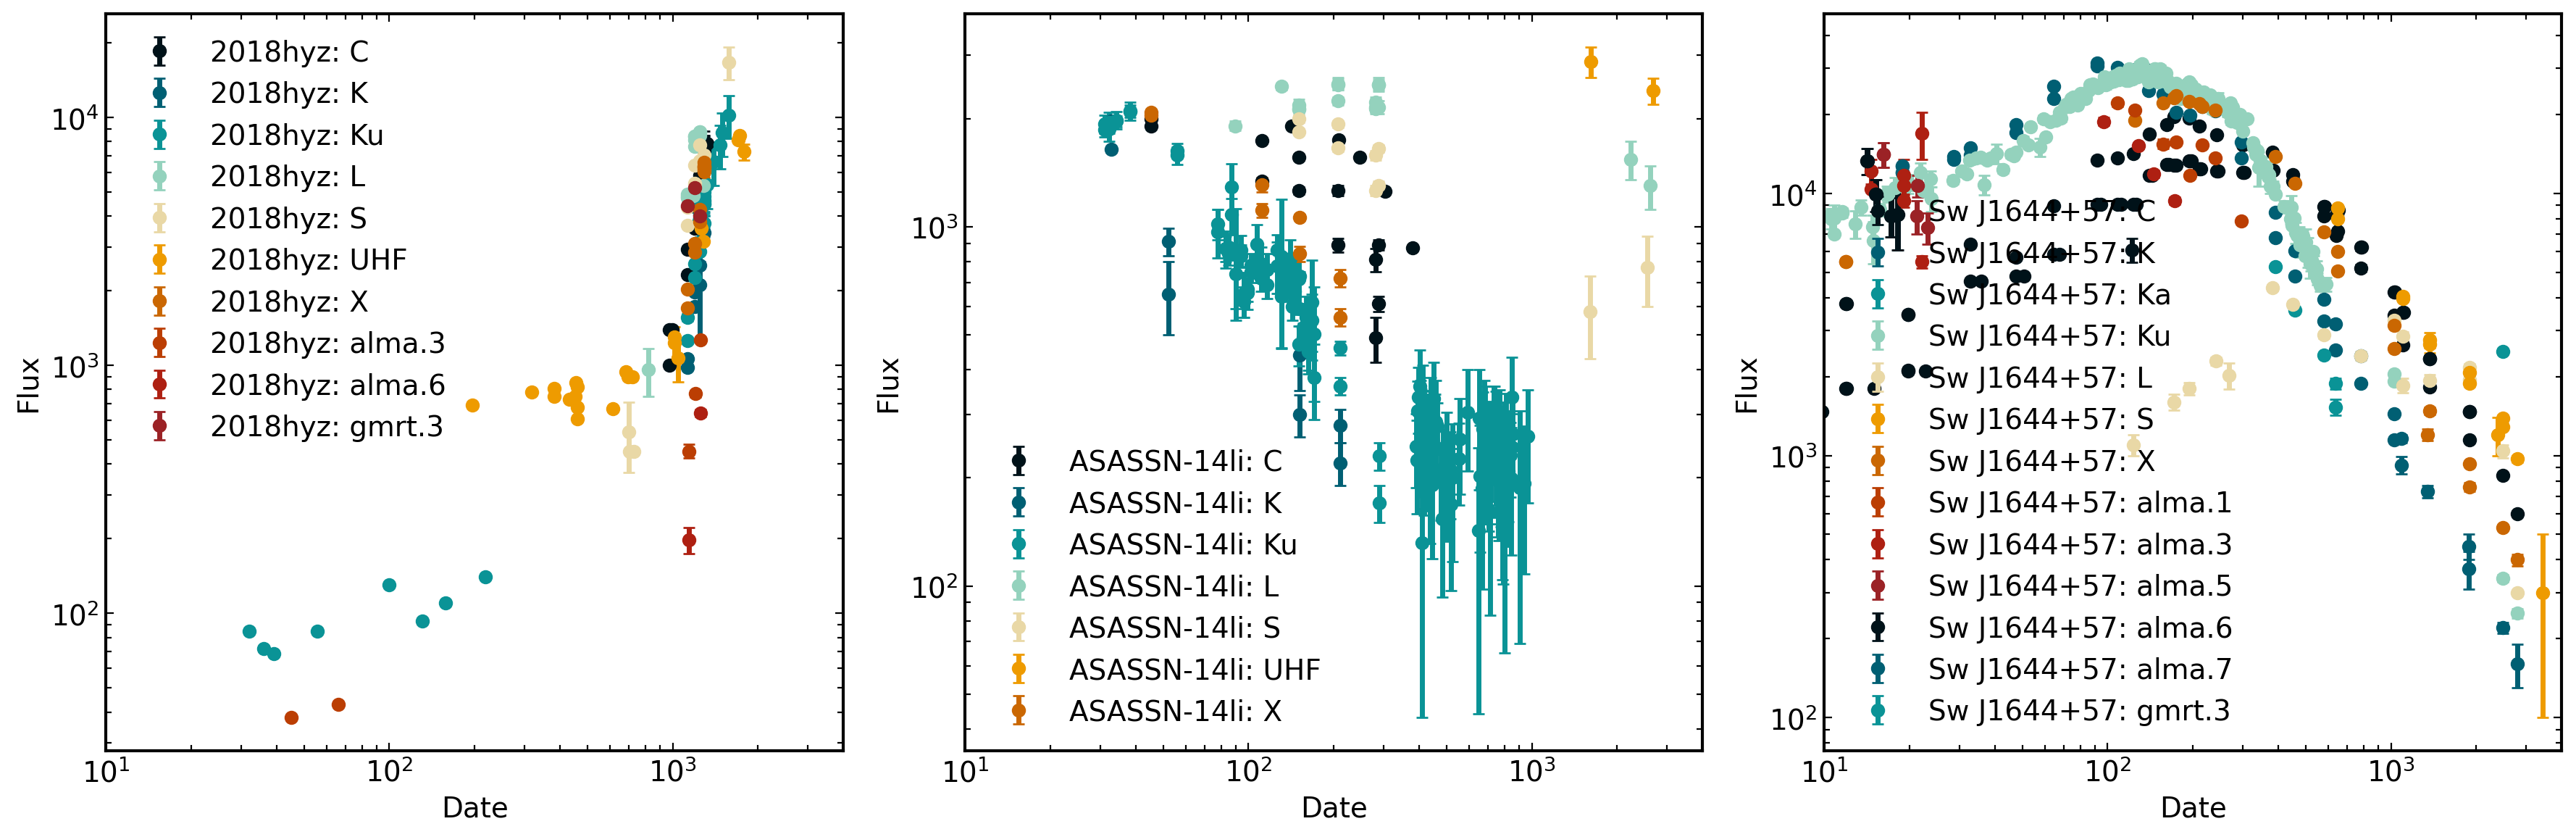

In [16]:
fig, axs = plt.subplots(1,3, figsize=(18,6))

for (name, data), ax in zip(radiophot.groupby('name'), axs):
    
    discovery_date = db.get_meta(names=name)[0].get_discovery_date().mjd
    
    for (f, df) in data.groupby('filter_name'):
        fig = otter.plotter.plotter.plot_light_curve(date=df.converted_date - discovery_date, 
                                             flux=df.converted_flux,
                                             flux_err=df.converted_flux_err,
                                             ax=ax,
                                             fig=fig,
                                             marker='o',
                                             linestyle='none',
                                             label=f'{name}: {f}')
        
    ax.legend()
    ax.set_xlim(10,4000)
    ax.set_xscale("log")
    ax.set_yscale("log")

Where the colors represent the observation frequency! Obviously these are not pubblication ready but they are at least a good way to easily visualize the data while working with it.